# Calculations For Greenspace & Crime
This project uses three endpoints from the Seattle Open Data API. A brief explaination of these endpoints is as follows:
- [**Seattle Neighborhood**](https://data-seattlecitygis.opendata.arcgis.com/datasets/SeattleCityGIS::city-clerk-neighborhoods/about) a database that gives the geo coordinates for the different neighborhoods within Seattle   
- [**Seattle Public Spaces**](https://data-seattlecitygis.opendata.arcgis.com/datasets/SeattleCityGIS::publicspaceseattle-entrypts/explore?location=47.611555%2C-122.355840%2C11.46) which is an overview of parks in Seattle which are open to the public and contain more information about what activites are present there. 
- [**SPD Crime Data 2008 - Present**](https://data.seattle.gov/Public-Safety/SPD-Crime-Data-2008-Present/tazs-3rd5) which tracks the crime in Seattle. This is to discovery what the crime rates are like, and what times of crime happen in which neighborhoods. Is there any correlation to the type of art and type of crime? Or amount of art/cutlure and amount of crime? I will be focusing on data from after 2017, to focus on the last 5 years of crime in the Seattle Area
---
**Step 0:** We begin by importing all the neccesary functionality we need for this project including tools for mapping, and api calling. We then set critical global variables such as api endpoints and the number of entries that each of these calls returns. You may need to run 'pip install geopandas' in the terminal for this to run properly.

In [48]:
#download request library, a bundle of code for APIs
import requests
import json
from pprint import pprint
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon, shape, Point
import csv
from pandas.io.json import json_normalize
import plotly.graph_objects as go
from shapely import geometry 
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry import shape
from geopandas import GeoSeries
import plotly.graph_objects as go
import plotly.express as px

#api endpoints
greenspace_endpoint = "https://services.arcgis.com/ZOyb2t4B0UYuYNYH/arcgis/rest/services/Public_and_Open_Spaces_in_Seattle_WFL1/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
crime_endpoint = "https://data.seattle.gov/resource/tazs-3rd5.json"
neighborhood_endpoint = "https://services.arcgis.com/ZOyb2t4B0UYuYNYH/arcgis/rest/services/nma_nhoods_main/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"

#the number of entries for each api 
greenspace_limit = 3614
crime_limit = 997000

## Section 1 - Calling The APIs & Formatting Hood_counts
**Step 1:** Queries Seattle Neighborhood Database. This code creates a "hood_counts" dictionary to track all the information from the endpoint about crime counts, crime types, park counts, park ratings, geographic information about the nieghborhoods. 

In [2]:
hood_counts = {}
hoods = requests.get(neighborhood_endpoint)
hood_data = hoods.json()
for hood in hood_data['features']:
    hood_name = hood['properties']['L_HOOD']
    #rint(hood_name + " " + str(len(hood['geometry']['coordinates'][0])))
    if hood['geometry']['type'] == "Polygon":
        p1 = Polygon(hood['geometry']['coordinates'][0])
        polygon = GeoSeries([p1])
    elif hood['geometry']['type'] == 'MultiPolygon':    
        #polygon = Polygon([tuple(1) for 1 in hood['geometry']['coordinates'][0]])
        poly: Polygon = shape(hood['geometry'])
        polygon = GeoSeries(poly)
    hood_counts[hood_name] = {}
    hood_counts[hood_name]['geometry'] = polygon
    hood_counts[hood_name]['most_common_crime'] = ""
    hood_counts[hood_name]['crime_count'] = 0 
    #hood_counts[hood_name]['crime_types'] = {}
    hood_counts[hood_name]['park_count'] = 0
    hood_counts[hood_name]['park_ratings'] = {}
    hood_counts[hood_name]['average_park_rating'] = 0 

**Step 2:** Queries Seattle Public Spaces Database. Then, we loop through the neighborhoods and their geolocation from step 1 while also looping through the data gathered from the Seattle Public Spaces Database. If the park is open, public and contains either forest or greensapce, we create a shapely point based on the longitude and latitude of the greenspace and check to see which neighborhood it belongs in. Then, in the hood_counts dictionary at the neighborhood it is inside of, we add the values for rating of this park, the name of the park, and the count of the parks within the given neighborhood. 

In [3]:
#retrieves all data from the art endpoint and creates a dictionary that lists the name, date 
#and point of all art projects and counts the number of pieces that do not fit this data criteria 
space_limits = {"$limit" : greenspace_limit}
spacey = requests.get(greenspace_endpoint, params= space_limits)
space_data = spacey.json()
total_parks = 0
space_list = space_data['features']
for hood in hood_data['features']:
    hood_name = hood['properties']['L_HOOD']
    polygon = shape(hood['geometry'])
    for space in space_list:
        if space['properties']['PUB_PRV'] == "PUBLIC" and space['properties']['STATUS'] == "OPEN": 
            if (space['properties']['GREENSPACE'] == "Y" or space['properties']['NATURAL'] == "Y"):
                longitude = space['geometry']['coordinates'][0]
                latitude = space['geometry']['coordinates'][1]
                tier = space['properties']['TIER']
                name = space['properties']['AREA_NAME']
                point = Point (float(longitude), float(latitude))
                if polygon.contains(point):
                    total_parks += 1
                    if tier not in hood_counts[hood_name]['park_ratings'].keys():
                        hood_counts[hood_name]['park_ratings'][tier] = 1
                    else: 
                        hood_counts[hood_name]['park_ratings'][tier] =  hood_counts[hood_name]['park_ratings'][tier] + 1
                    hood_counts[hood_name]['park_count'] += 1         

**Step 3:** Queries Seattle Crime Database. Then, we loop through the neighborhoods and their geolocation from step 1 while also looping through the data gathered from the Seattle Public Spaces Database. If the crime is within the last 5 years (2017 - 2022), we create a shapely point based on the longitude and latitude of the crime and check to see which neighborhood it belongs in. Then, in the hood_counts dictionary at the neighborhood it is inside of, we add the values for type of crime, and the count of the crime incidences within the given neighborhood. 

In [4]:
#retrieves all data from the art endpoint and creates a dictionary that lists the name, date 
#and point of all art projects and counts the number of pieces that do not fit this data criteria 
crime_limits = {"$select" :"report_datetime, Offense_ID, Offense_Parent_Group, MCPP, Offense, Longitude, Latitude", 
                "$where" : "report_datetime > '2022-01-01T00:00:00'",              
                "$limit": crime_limit #change
               }
#"$where" : "report_datetime > '2017-01-01T00:00:00'",              
crime_end = requests.get(crime_endpoint, params = crime_limits)
crime_data = crime_end.json()
for c in crime_data:
    for hood in hood_data['features']:
        hood_name = hood['properties']['L_HOOD']
        polygon = shape(hood['geometry'])
        point = Point(float(c['Longitude']), float(c['Latitude']))
        if polygon.contains(point):
            hood_counts[hood_name]['crime_count'] += 1

32059


**Step 4:** Loops through hood_counts to calculate average park rating for each neighborhood

In [5]:
for hood in hood_counts:
    total_rating = 0
    num_ratings = 0
    for rating in hood_counts[hood]['park_ratings']:
        rating_sum = int(rating) * hood_counts[hood]['park_ratings'][rating]
        num_ratings += hood_counts[hood]['park_ratings'][rating]
        total_rating = total_rating + rating_sum 
        hood_counts[hood]['average_park_rating'] = total_rating/num_ratings
print(hood_counts)

{'Ballard': {'geometry': 0    POLYGON ((-122.40266 47.69602, -122.40236 47.6...
dtype: geometry, 'most_common_crime': '', 'crime_count': 1402, 'park_count': 52, 'park_ratings': {3: 8, 5: 24, 4: 17, 1: 3}, 'average_park_rating': 4.134615384615385}, 'Beacon Hill': {'geometry': 0    POLYGON ((-122.31281 47.59581, -122.31216 47.5...
dtype: geometry, 'most_common_crime': '', 'crime_count': 1175, 'park_count': 93, 'park_ratings': {5: 3, 4: 57, 3: 26, 2: 7}, 'average_park_rating': 3.6021505376344085}, 'Capitol Hill': {'geometry': 0    MULTIPOLYGON (((-122.29599 47.64184, -122.2960...
dtype: geometry, 'most_common_crime': '', 'crime_count': 2226, 'park_count': 107, 'park_ratings': {5: 32, 3: 43, 4: 20, 2: 6, 1: 6}, 'average_park_rating': 3.616822429906542}, 'Cascade': {'geometry': 0    POLYGON ((-122.32124 47.65231, -122.32113 47.6...
dtype: geometry, 'most_common_crime': '', 'crime_count': 1057, 'park_count': 42, 'park_ratings': {4: 26, 5: 5, 3: 11}, 'average_park_rating': 3.857142857142857},

## Section 2 - Data Analysis & Charts! 
**Step 1:** creates dict hood_percentages which creates a key for crime_percent and an key for park_percent, which takes the total number of crimes and parks for each neighborhoods and divides it by the . Then, it creates two lists based on whether the percentage of parks or crime is greater for each neighborhood. These lists assoicate the neighborh
ood with the average park rating. The final value of these dictionaries is the average of all ratings within the given value of more parks than crime, or more crime than parks. 

In [37]:
#dict that tracks the percent of crimes and ratings
hood_percentages = {}
crime_total = 0
park_total = 0

#creates lists that 
low_crime_high_park = []
high_crime_low_park = []
low_crime_high_park_rating_sum = 0
high_crime_low_park_rating_sum = 0

for hood in hood_counts:
    crime_total += hood_counts[hood]['crime_count']
    park_total += hood_counts[hood]['park_count']

for hood in hood_counts:
    hood_percentages[hood] = {}
    hood_percentages[hood]['crime_percent'] = round(((hood_counts[hood]['crime_count'] / crime_total) * 100),2)
    hood_percentages[hood]['park_percent'] = round(((hood_counts[hood]['park_count'] / park_total) * 100),2)
    if hood_percentages[hood]['crime_percent'] < hood_percentages[hood]['park_percent']:
        low_crime_high_park.append({hood: hood_counts[hood]['average_park_rating']})
        low_crime_high_park_rating_sum += hood_counts[hood]['average_park_rating']
    else:
        high_crime_low_park.append({hood: hood_counts[hood]['average_park_rating']})
        high_crime_low_park_rating_sum += hood_counts[hood]['average_park_rating']

low_crime_high_park_rating_sum = low_crime_high_park_rating_sum / len(low_crime_high_park)
high_crime_low_park_rating_sum= high_crime_low_park_rating_sum / len(high_crime_low_park)
low_crime_high_park.append({'Average': low_crime_high_park_rating_sum})
high_crime_low_park.append({'Average' : high_crime_low_park_rating_sum})

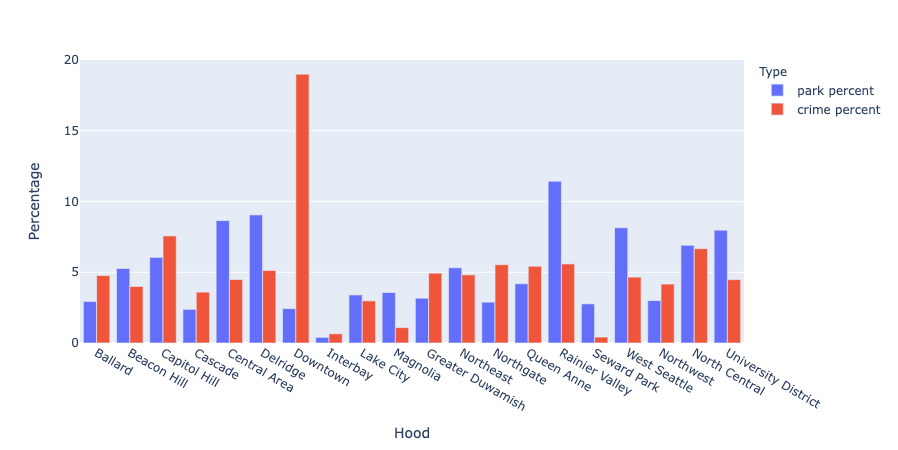

In [36]:
Hood = []
Type = []
Count = []
for hood in hood_percentages:
    Hood.append(hood)
    Hood.append(hood)
    Type.append("park percent")
    Count.append(hood_percentages[hood]["park_percent"])
    Type.append("crime percent")
    Count.append(hood_percentages[hood]["crime_percent"])
df = pd.DataFrame({
    "Hood": Hood,
    "Type": Type,
    "Percentage": Count
})
fig = px.bar(df, x="Hood", y="Percentage", color='Type', barmode="group")
fig.show()

### RQ2 - Does the the quality of parks in the area affect the amount of crime? 

**Step 3:** creates a graph that represents the average park rating for the areas that have higher percentage of parks when comapred to the percentage of crimes

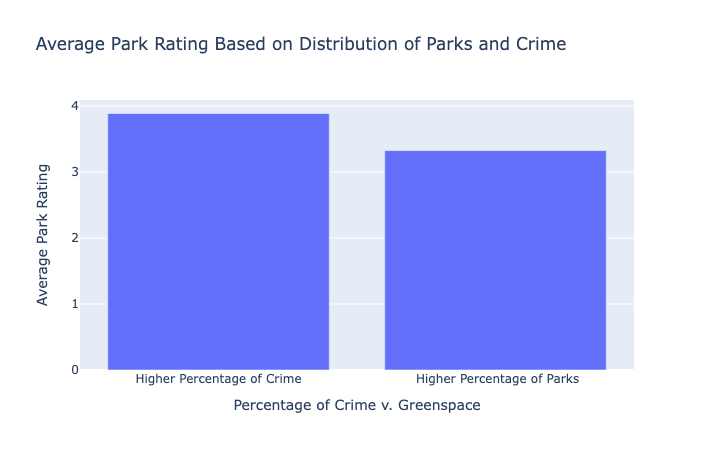

In [49]:
Hood = ['Higher Percentage of Crime', ' Higher Percentage of Parks']
Type = ['High Crime Area Park Rating', 'Low Crime Area Park Rating']
Count = [high_crime_low_park[len(high_crime_low_park) - 1]['Average'],low_crime_high_park[len(low_crime_high_park) - 1]['Average']]
df =  pd.DataFrame({
    "Percentage of Crime v. Greenspace": Hood,
    "Type": Type,
    "Average Park Rating": Count
})
fig = px.bar(df, x="Percentage of Crime v. Greenspace", y="Average Park Rating", barmode="group", title="Average Park Rating Based on Distribution of Parks and Crime")
fig.show()